## Exercise: Conversion Rate

In [1]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os
exec(open("my_functions.py").read())

In [2]:
#load data
dat = pd.read_csv('conversion_data.csv')
dat.head()

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


Text(0.5, 1.0, 'conversion rate by country and source')

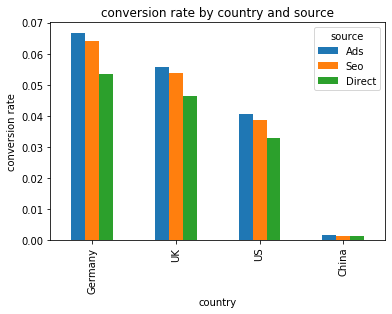

In [3]:
#break down conversion rate by source and country
rates = get_conversion(dat, ["source", "country"])
wide_rates = rates.pivot(index='country', columns='source', values='c_rate')
wide_rates['country'] = wide_rates.index.values
wide_rates.sort_values(by='Ads', ascending=False, inplace=True)
ax = wide_rates.plot(x="country", y=["Ads", "Seo", "Direct"], kind="bar")
ax.set_xlabel("country")
ax.set_ylabel("conversion rate")
ax.set_title("conversion rate by country and source")

Breakdown of conversion rate by country and source shows consistently ranked conversion rates for the sources, and substantially lower conversion rates for China

Text(0.5, 1.0, 'conversion rate by total pages visited')

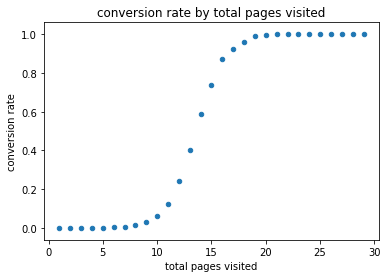

In [4]:
#conversion rate by total pages visited
rates = get_conversion(dat, ['total_pages_visited'])
ax = rates.plot(x='total_pages_visited', y='c_rate', kind='scatter')
ax.set_xlabel("total pages visited")
ax.set_ylabel("conversion rate")
ax.set_title('conversion rate by total pages visited')

Plot of conversion rate by total pages visited demonstrates that the number of pages visited is strongly predictive of conversion. Moreover, there appears to be a threshold or tipping point around 12 visites where conversion becomes much much likely.

Text(0.5, 1.0, 'conversion rate by age')

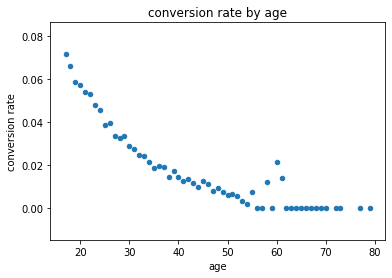

In [5]:
#conversion rate by age
rates = get_conversion(dat, ['age'])
rates = rates[rates['age'] < 90]
ax = rates.plot(x='age', y='c_rate', kind='scatter')
ax.set_xlabel("age")
ax.set_ylabel("conversion rate")
ax.set_title('conversion rate by age')

Plot of conversion rate by age demonstrates younger visitors have much higher conversion rates

In [13]:
#PREPARE DATA FOR MODELING
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
y = dat['converted']
X = dat.drop('converted', 1)

#make dummy variables for categorical features
to_onehot = ['country','source']
X = pd.get_dummies(X, columns = to_onehot, drop_first = True)

#scale the dataframe
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X[X.columns] = scaler.fit_transform(X[X.columns])

#split out a traingin and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=321)

Prepare data for modeling by converting categorical features into 'dummy' variables with one hot encoding. Also scale the features so that the model coefficients will be comparable. Finally set aside a test set to evaluate model performance.

In [14]:
#FIT MODEL

#logistic regression
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(max_iter=1000)

#train
log_reg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Select logistic regression for predictive model. Logistic regression is well-suited to the situation because the model coefficients can be interpreted intuitively for decision making on how to improve conversion rate.

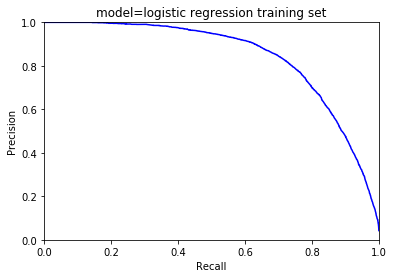

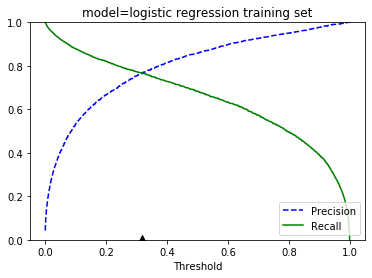

Confusion matrix for threshold = 0.32:
[[212525   1663]
 [  1672   5480]]
Classification report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    214188
           1       0.77      0.77      0.77      7152

    accuracy                           0.98    221340
   macro avg       0.88      0.88      0.88    221340
weighted avg       0.98      0.98      0.98    221340



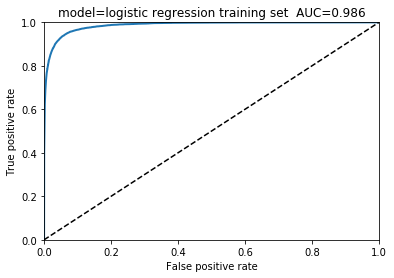

In [15]:
#performance on the training set
probs_train = log_reg.predict_proba(X_train)
scores_train = probs_train[:, 1]
train_perf = get_model_performance('logistic regression training set', X_train, scores_train, y_train, pos_label=1)

Model performance based on the training set. I used the area under the ROC curve (AUC) as measure of model performance. Value close to 1 indicates the model performs well both in terms of sensitivity to positive outcomes (predicting conversions when they really did occur) and avoiding false positives (the model rarely predicts conversions when they did not occur).

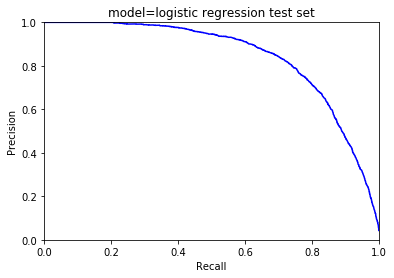

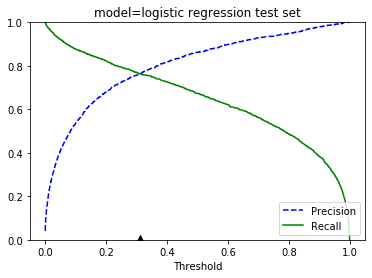

Confusion matrix for threshold = 0.31:
[[91094   718]
 [  721  2327]]
Classification report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     91812
           1       0.76      0.76      0.76      3048

    accuracy                           0.98     94860
   macro avg       0.88      0.88      0.88     94860
weighted avg       0.98      0.98      0.98     94860



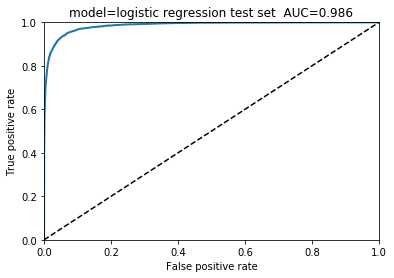

In [16]:
#performance on the test set
probs_test = log_reg.predict_proba(X_test)
scores_test = probs_test[:, 1]
test_perf = get_model_performance('logistic regression test set', X_test, scores_test, y_test, pos_label=1)

Nearly identical peformance results when the model is applied to the test set indicates the model is generally good at predicting conversion, and was not overfit to the training set.

Text(0.5, 1.0, 'absolute feature coefficients')

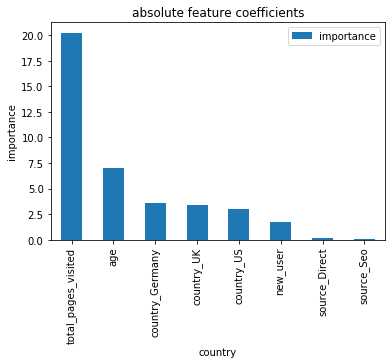

In [17]:
#RECOMMENDATION

#get coefficients
coef_df = pd.DataFrame({'feature': X_train.columns, 'coef': log_reg.coef_.tolist()[0]})
coef_df['importance'] = abs(coef_df['coef'])
coef_df = coef_df.sort_values('importance', ascending=False)
coef_df

#plot barplot
ax = coef_df.plot(x="feature", y='importance', kind="bar")
ax.set_xlabel("country")
ax.set_ylabel("importance")
ax.set_title('absolute feature coefficients')

Plot of absolute coefficients illustrates the importance of the features in predicting conversion. Total pages visited is by far the strongest predictor. Hence any a strategy to increase the number of pages visited could potentially improve conversion rate. Getting users to visit more than 10 pages is especially important. 

The next most important feature was age. Younger users are much more likely to be converted. A strategy targetted at increasing the proportion of younger visitors could potentially increase the overall conversion rate.

As indicated in the breakdown by country, Chinese citizens have substantially lower conversion rates, the differences between Germany, UK, and US are only of marginal importance.

Being a return users also predicts higher conversion rate, hence getting users to return is important.

Finally, all other things considered, the source is relatively unimportant. It appears to matter not so much what brought the user to the pages, but their interest, captured best by the number of pages they visit.